In [16]:
import pandas as pd
import os
from tqdm import tqdm

# Define the directory where your CSV files are located
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/"  # Replace with your folder path
output_file = "Eredivisie Coach 2024-2025.xlsx"  # Replace with the desired output file path

# Create a list to store all results
all_results = []

# Loop through all CSV files in the folder
for file_name in tqdm(os.listdir(folder_path), desc="Processing Files"):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Identify columns with '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Precompute the endX and endY columns, initialized with 0.0
        df['endX'] = 0.0
        df['endY'] = 0.0

        # Create dictionaries to map from index to the correct qualifier columns
        qualifier_value_cols = {int(col.split('/')[1]): col for col in df.columns if 'qualifier' in col and 'value' in col}

        # Use tqdm to add a progress bar to iterate over rows
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
            for j, type_col in enumerate(type_cols):
                # Check for typeId 140 and update 'endX'
                if row[type_col] == 140:
                    endx_col = qualifier_value_cols.get(j)
                    if endx_col:  # Ensure that the column exists
                        df.at[index, 'endX'] = row[endx_col]
                
                # Check for typeId 141 and update 'endY'
                elif row[type_col] == 141:
                    endy_col = qualifier_value_cols.get(j)
                    if endy_col:  # Ensure that the column exists
                        df.at[index, 'endY'] = row[endy_col]

        # Ensure relevant columns are numeric
        df['x'] = pd.to_numeric(df['x'], errors='coerce')
        df['y'] = pd.to_numeric(df['y'], errors='coerce')
        df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
        df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

        # Filter dataframes as before
        df_long_balls = df.loc[(df['typeId'] == 1) & (df['x'] < 30) & (df['endX'] > 50)]
        df_deep_circulations = df.loc[(df['typeId'] == 1) & (df['x'] > 30) & (df['x'] < 60) & (df['y'] > 22) & (df['y'] < 78) & (df['endX'] > 30) & (df['endX'] < 60)]
        df_wing_play = df.loc[(df['typeId'] == 1) & (df['x'] > 30) & (df['x'] < 60) & (df['y'] > 22) & (df['y'] < 78) & ((df['endY'] < 22) | (df['endY'] > 78))]
        df_final_third = df.loc[(df['typeId'] == 1) & (df['x'] > 70)]
        df_crossing = df.loc[
            (df['typeId'] == 1) & 
            (df['x'] > 50) & 
            ((df['y'] <= 22) | (df['y'] >= 78)) & 
            (df['endY'] >= 22) & 
            (df['endY'] <= 78) & 
            (df['endX'] > 85)
        ]
        df_opposition_passes = df.loc[df['typeId'] == 1]
        df_defensive_actions = df.loc[df['typeId'].isin([7, 8])]

        # Perform the same counting and calculations as in your original code
        long_balls_count = df_long_balls.groupby('contestantId').size().reset_index(name='Long balls')
        deep_circulations_count = df_deep_circulations.groupby('contestantId').size().reset_index(name='Deep circulation')
        wing_play_count = df_wing_play.groupby('contestantId').size().reset_index(name='Wing play')
        final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')
        crossing_count = df_crossing.groupby('contestantId').size().reset_index(name='Crossing')
        opposition_passes_count = df_opposition_passes.groupby('contestantId').size().reset_index(name='Opposition passes')
        defensive_actions_count = df_defensive_actions.groupby('contestantId').size().reset_index(name='Defensive actions')

        # Calculate the total number of final third passes across all contestants
        total_final_third_passes = df_final_third.shape[0]

        # Calculate the percentage of final third passes for each contestantId
        final_third_count['Territory'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

        # Create Low Block column
        df['Low Block'] = df.apply(lambda row: 1 if row['typeId'] in [7, 8, 12] and row['x'] < 25 else 0, axis=1)

        # Calculate total number of typeId 7, 8, 12 actions across the pitch
        total_defensive_actions = df.loc[df['typeId'].isin([7, 8, 12])].shape[0]

        # Calculate Low Block percentage per contestantId
        low_block_count = df.groupby('contestantId')['Low Block'].sum().reset_index(name='Low Block')
        low_block_count['Low Block'] = (low_block_count['Low Block'] / total_defensive_actions) * 100

        # Add the new "Counters" column
        def find_counters(df):
            counters = []
            for i in range(len(df)):
                if df.iloc[i]['typeId'] == 49 and df.iloc[i]['x'] < 50:
                    found_counter = False
                    for j in range(i + 1, min(i + 4, len(df))):
                        if df.iloc[j]['typeId'] == 1 and df.iloc[j]['x'] > 70:
                            found_counter = True
                            break
                    counters.append(1 if found_counter else 0)
                else:
                    counters.append(0)
            return counters

        # Apply the function to add the "Counters" column
        df['Counters'] = find_counters(df)

        # Aggregate "Counters" by contestantId
        counters_count = df.groupby('contestantId')['Counters'].sum().reset_index(name='Counters')

        # Merge the counts into a single dataframe
        result = pd.merge(long_balls_count, deep_circulations_count, on='contestantId', how='outer').fillna(0)
        result = pd.merge(result, wing_play_count, on='contestantId', how='outer').fillna(0)
        result = pd.merge(result, final_third_count[['contestantId', 'Territory']], on='contestantId', how='outer').fillna(0)
        result = pd.merge(result, crossing_count, on='contestantId', how='outer').fillna(0)
        result = pd.merge(result, opposition_passes_count, on='contestantId', how='left').fillna(0)
        result = pd.merge(result, defensive_actions_count, on='contestantId', how='left').fillna(0)

        # Calculate High Press as the ratio of opposition passes from other contestants to defensive actions
        total_opposition_passes = df_opposition_passes.groupby('contestantId').size().sum()

        result['High Press'] = result.apply(
            lambda row: (total_opposition_passes - row['Opposition passes']) / row['Defensive actions'] if row['Defensive actions'] > 0 else 0, 
            axis=1
        )

        # Merge the Low Block and Counters with the result DataFrame
        result = pd.merge(result, low_block_count, on='contestantId', how='left').fillna(0)
        result = pd.merge(result, counters_count, on='contestantId', how='left').fillna(0)

        # Drop intermediate columns if not needed
        result = result.drop(columns=['Opposition passes', 'Defensive actions'])

        # Ensure the columns are integers where appropriate
        result['Long balls'] = result['Long balls'].astype(int)
        result['Deep circulation'] = result['Deep circulation'].astype(int)
        result['Wing play'] = result['Wing play'].astype(int)
        result['Crossing'] = result['Crossing'].astype(int)
        result['High Press'] = result['High Press'].astype(float)  # Ensure High Press is float

        # Append the result to all_results
        all_results.append(result)

# Combine all results into one dataframe
final_result = pd.concat(all_results, ignore_index=True)

# Calculate the averages per contestantId
averages_per_contestant = final_result.groupby('contestantId').mean()

# Save the results to an Excel file
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, sheet_name='Aggregated Data', index=False)
    averages_per_contestant.to_excel(writer, sheet_name='Averages per Contestant', index=True)

print(f"Processing completed. Results saved to {output_file}.")


Processing Rows:   0%|                                 | 0/1712 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1675/1675 [00:00<00:00, 2155.88it/s]


Processing Rows: 100%|████████████████████| 1600/1600 [00:00<00:00, 3274.76it/s]


Processing Rows:  21%|████▍                | 363/1708 [00:00<00:00, 1814.04it/s]


Processing Rows:  32%|██████▊              | 620/1921 [00:00<00:00, 3010.20it/s]


Processing Rows:   0%|                                 | 0/1697 [00:00<?, ?it/s]


Processing Rows:   0%|                                 | 0/1703 [00:00<?, ?it/s]


Processing Rows:  23%|████▉                | 368/1566 [00:00<00:00, 3673.39it/s]


Processing Rows:  38%|████████             | 671/1756 [00:00<00:00, 3387.43it/s]


Processing Rows: 100%|████████████████████| 1740/1740 [00:00<00:00, 2921.23it/s]


Processing Rows:  21%|████▌                | 339/1580 [00:00<00:00, 3386.58it/s]


Processing Rows:   0%|                                 | 0/1827 [00:00<?, ?it/s]


Processing Rows:   0%|                                 | 0/1767 [00:00<?, ?it/s]


Processing Files: 100%|███████████████████████| 195/195 [03:37<00:00,  1.12s/it]


Processing completed. Results saved to Eredivisie Coach 2024-2025.xlsx.


In [28]:
import pandas as pd

# Define the path to the existing Excel file
input_file = "Eredivisie Coach 2024-2025.xlsx"  # Replace with your input file path
output_file = "Eredivisie Coach 2024-2025.xlsx"  # Replace with desired output file path

# Load the existing Excel file
xls = pd.ExcelFile(input_file)


# Load the "Aggregated Data" sheet (or the sheet with your player stats)
final_result = pd.read_excel(xls, sheet_name='Aggregated Data')

# Define the columns to calculate the percentile ranks for
columns_to_rank = ['Long balls', 'Deep circulation', 'Wing play', 'Territory', 'Crossing', 'High Press', 'Low Block', 'Counters']

# Calculate the percentile ranks per contestantId for each of the defined columns
percentile_ranks = final_result[columns_to_rank].rank(pct=True, method='average')

# Rename columns to include "Percentile Rank"
percentile_ranks.columns = [col + ' Percentile Rank' for col in percentile_ranks.columns]

# Merge the percentile ranks back into the final_result DataFrame
final_result = pd.concat([final_result, percentile_ranks], axis=1)

# Try loading the "Averages per Contestant" sheet if it exists
try:
    averages_per_contestant = pd.read_excel(xls, sheet_name='Averages per Contestant')
    # Merge the averages per contestant into the final result if the sheet exists
    final_result = pd.merge(final_result, averages_per_contestant, on='contestantId', how='left')
except ValueError:
    print("'Averages per Contestant' sheet not found. Skipping this step.")

# Calculate the average for each contestantId for all columns
final_result = final_result.groupby('contestantId', as_index=False).mean()

# Save everything into one sheet in the output Excel file
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, index=False)

print(f"Processing completed. Modified results saved to {output_file}.")


ValueError: Worksheet named 'Aggregated Data' not found

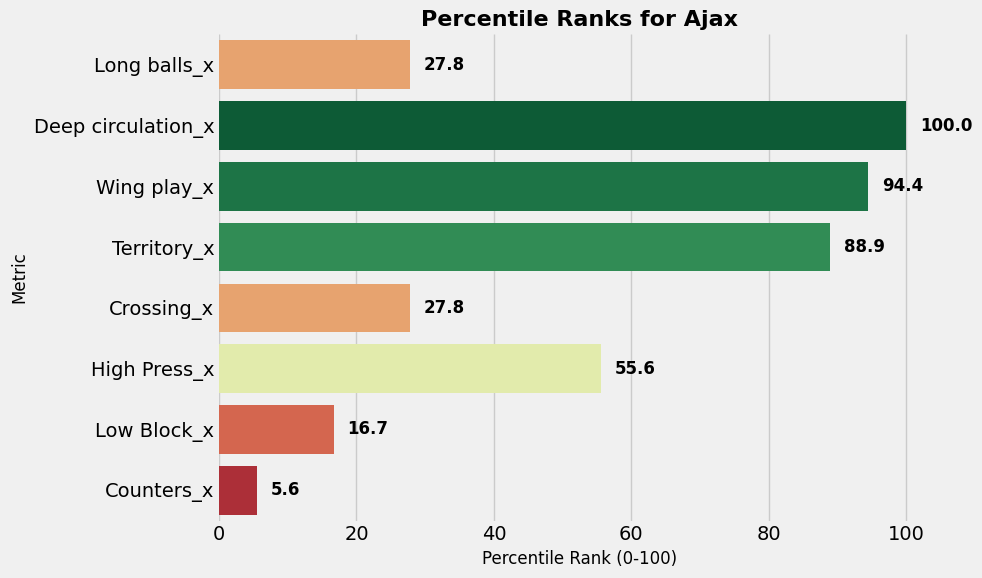

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Load the mapping file (Replace with your actual file path)
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'
mapping_df = pd.read_excel(mapping_file_path)

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# Assuming final_result contains the aggregated data
final_result.columns = final_result.columns.str.strip()  # Clean column names

# Merge final_result with mapping_df to add the 'team' column
final_result['team'] = final_result['contestantId'].map(id_to_team)

# Filter for Ajax team
ajax_data = final_result[final_result['team'] == 'Ajax']

if not ajax_data.empty:
    # List of columns to rank
    columns_to_rank = ['Long balls_x', 'Deep circulation_x', 'Wing play_x', 'Territory_x', 
                       'Crossing_x', 'High Press_x', 'Low Block_x', 'Counters_x']

    # Check if columns exist
    missing_columns = [col for col in columns_to_rank if col not in ajax_data.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    else:
        # Calculate percentile ranks (scale to 0-100) across all teams
        percentile_ranks = final_result[columns_to_rank].apply(lambda x: x.rank(pct=True) * 100, axis=0)

        # Extract percentile ranks for Ajax players
        ajax_percentiles = percentile_ranks[final_result['team'] == 'Ajax'].mean()  # Take mean if multiple players

        # Define a red-green color gradient based on values
        norm = plt.Normalize(0, 100)
        colors = sns.color_palette("RdYlGn", as_cmap=True)(norm(ajax_percentiles.values))

        # Create a horizontal bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = sns.barplot(x=ajax_percentiles.values, y=ajax_percentiles.index, palette=colors, ax=ax)

        # Add values at the end of bars
        for bar, value in zip(bars.patches, ajax_percentiles.values):
            ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, f"{value:.1f}", 
                    ha='left', va='center', fontsize=12, fontweight='bold')

        # Add titles and labels
        ax.set_title("Percentile Ranks for Ajax", fontsize=16, fontweight='bold')
        ax.set_xlabel('Percentile Rank (0-100)', fontsize=12)
        ax.set_ylabel('Metric', fontsize=12)

        # Remove unnecessary chart borders for a cleaner look
        sns.despine(left=True, bottom=True)

        # Show the plot
        plt.tight_layout()
        plt.show()
else:
    print("No data found for Ajax.")
